# 목차
1. 데이터 탐색
2. 데이터 전처리
3. Modeling
4. 최종 결과



# Requirement
1. Folder

> - 실행하는 폴더에 AFSNT, AFSNT_DLY가 들어 있어야 함

2. Package

> - Python3.6
> - pandas, numpy, seaborn, catboost, scipy, sklearn, matplotlib

3. 필수 사항
>  **실행은 실행 파일로 해주세요**

# 1. 데이터 탐색

## 1.1 데이터 기본 정보 확인
- 데이터의 shape를 확인하고 null값이 있는 지 여부를 확인
- 일정한 값을 재현하기 위해 np.random.seed를 통해 랜덤 시드를 고정

In [0]:
# 라이브러리 임포트
!pip install catboost
!pip install category_encoders
!pip install -U imbalanced-learn

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score,classification_report,\
confusion_matrix ,recall_score,precision_score,roc_auc_score, roc_curve

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from scipy.stats import norm

from catboost import CatBoostClassifier
from catboost import Pool
np.random.seed(1)

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.5.0)


In [0]:
# 데이터 파일 읽어들이기 
data = pd.read_csv('AFSNT.csv',encoding='ms949')
test = pd.read_csv('AFSNT_DLY.csv',encoding='ms949')

In [0]:
# 행, 열 개수 확인
print(data.shape)
print(test.shape)

(987709, 17)
(16076, 12)


In [0]:
# 결측치 유무 확인
print(data.isnull().any())
print(test.isnull().any())

SDT_YY    False
SDT_MM    False
SDT_DD    False
SDT_DY    False
ARP       False
ODP       False
FLO       False
FLT       False
REG        True
AOD       False
IRR       False
STT       False
ATT       False
DLY       False
DRR        True
CNL       False
CNR        True
dtype: bool
SDT_YY      False
SDT_MM      False
SDT_DD      False
SDT_DY      False
ARP         False
ODP         False
FLO         False
FLT         False
AOD         False
STT         False
DLY          True
DLY_RATE     True
dtype: bool


In [0]:
data.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR
0,2017,1,1,일,ARP3,ARP6,J,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN
1,2017,1,1,일,ARP3,ARP6,J,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN
2,2017,1,1,일,ARP3,ARP6,J,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN
3,2017,1,1,일,ARP3,ARP6,J,J1957,SEw3NzE4,D,N,13:25,14:09,Y,C02,N,NaN
4,2017,1,1,일,ARP3,ARP6,J,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN


## 1.2 이상치 제거


*   결항은 대회에서 맞춰야 할 문제가 아니므로 삭제
*   부정기편은 시험 비행이나 원래 없는 노선을 가는 비행이고, test 데이터에는 없어서 제거

In [0]:
# 결항인 경우 데이터 삭제
data = data[data['CNL'] != 'Y']
# 부정기편 제거
data = data[data['IRR'] == 'N']

In [0]:
# reset index
data = data.reset_index(drop = True)

## 1.3 시각화

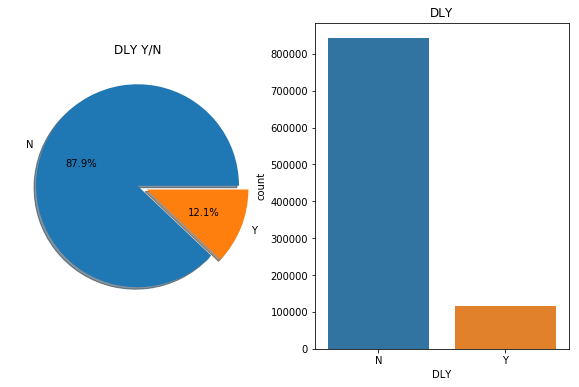

In [0]:
# DLY 시각화
f,ax = plt.subplots(1,2,figsize=(10,6))
data['DLY'].value_counts().plot.pie(explode = [0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('DLY Y/N')
ax[0].set_ylabel('')
sns.countplot('DLY',data=data,ax=ax[1])
ax[1].set_title('DLY')
plt.show()

- 지연인 항공편과 지연이 아닌 항공편의 비율이 상당히 불균형함


In [0]:
# 지연한 경우의 데이터만 추출
dly = data[data['DLY']=='Y']

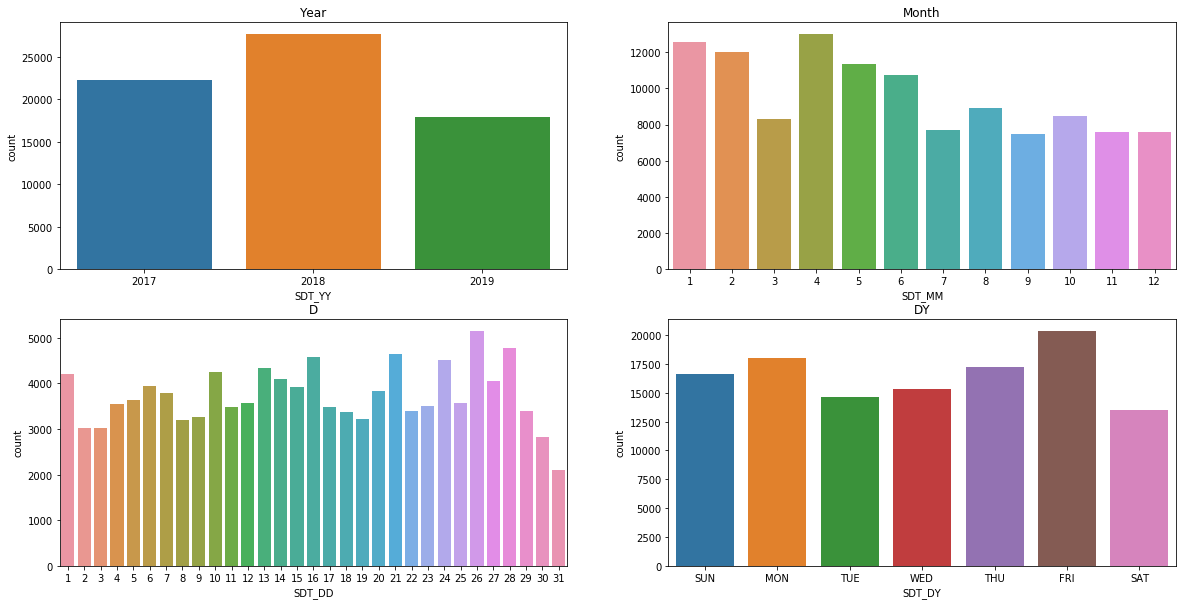

In [0]:
# SDT_YY, SDT_MM, SDT_DD, SDT_DY

f,ax = plt.subplots(2,2,figsize=(20,10))
sns.countplot('SDT_YY',data=dly[dly['SDT_MM']<=6],ax=ax[0][0])
sns.countplot('SDT_MM',data=dly,ax=ax[0][1])
sns.countplot('SDT_DD',data=dly,ax=ax[1][0])
day = dly
day = day.replace(['월', '화','수','목','금','토','일'],['MON','TUE','WED','THU','FRI','SAT','SUN'])
sns.countplot('SDT_DY',data=day,ax=ax[1][1])
ax[0][0].set_title('Year')
ax[0][1].set_title('Month')
ax[1][0].set_title('D')
ax[1][1].set_title('DY')

plt.show()

- 연도, 월, 일, 요일 별로 지연을 살펴 보았을 때, 뚜렷하지는 않지만 각각 항목별로 어느정도 차이가 있음
- 연도 별로는 19년도는 상반기 밖에 없어서 정확한 비교를 위해 상반기만 비교
- 2017년과 2018년에 비해 2019년은 확연히 지연률이 적어진 상태
- 3월은 다른 달보다 지연률이 적음
- 일 별로는 상당히 상이하게 지연이 분포되어 있어서 뚜렷한 특징은 잡지 못하지만 말일로 갈수록 지연이 적어짐
- 31일은 있는 달도 있고 없는 달도 있어서 적게 나온 것으로 추측
- 요일 별로는 대부분 비슷하지만 금요일이 가장 많이 지연되는 것으로 나왔고 이에 반해 토요일이 가장 적음

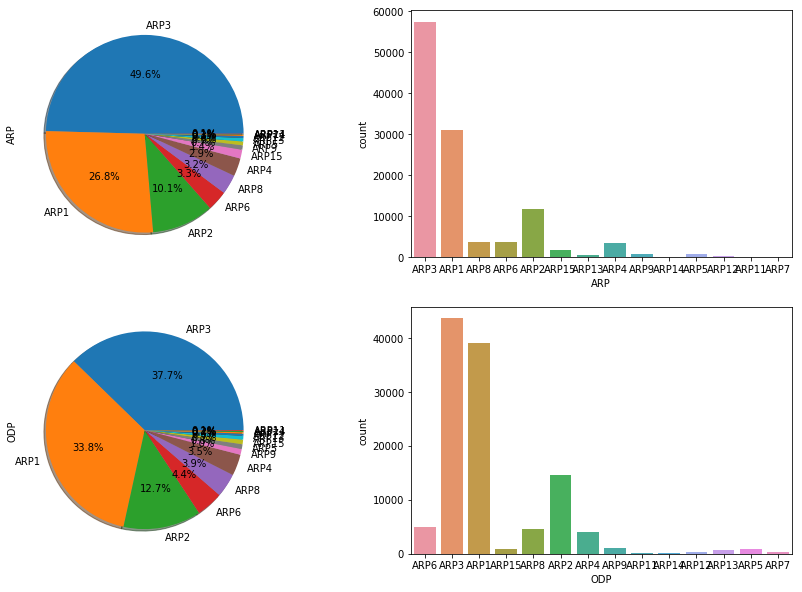

In [0]:
# ARP, ODP

f,ax = plt.subplots(2,2,figsize=(15,10))
dly['ARP'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0][0],shadow=True)
sns.countplot('ARP',data=dly,ax=ax[0][1])

dly['ODP'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1][0],shadow=True)
sns.countplot('ODP',data=dly,ax=ax[1][1])

- **위에 있는 그래프가 ARP, 밑에 있는 그래프가 ODP**
- 공항별로는 상위 3개의 공항은 공항, 상대 공항에 따라 차이가 크게 없음

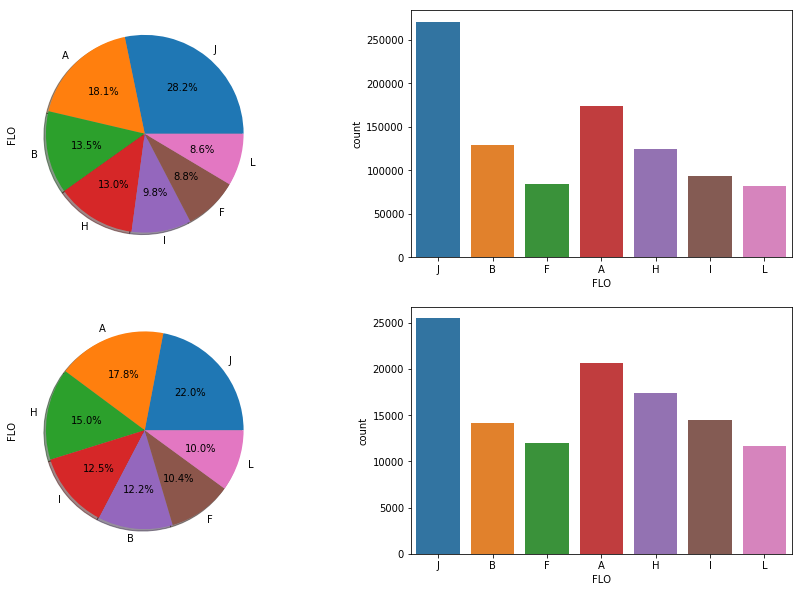

In [0]:
# FLO

f,ax = plt.subplots(2,2,figsize=(15,10))
data['FLO'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0][0],shadow=True)
sns.countplot('FLO',data=data,ax=ax[0][1])
dly['FLO'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1][0],shadow=True)
sns.countplot('FLO', data=dly, ax=ax[1][1])

- **위의 그래프가 원 데이터의 그래프고 밑의 그래프가 지연인 것의 그래프**
- 지연된 것의 그래프와 원 데이터의 그래프를 비교해보면 미미하지만 지연율이 조금 더 높은 항공사가 있음을 확인할 수 있음

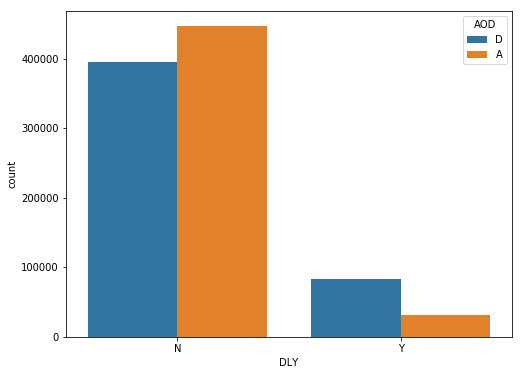

In [0]:
# AOD
f,ax = plt.subplots(figsize=(8,6))
sns.countplot('DLY',hue='AOD',data=data,ax=ax)
plt.show()

- 도착과 출발을 나눠서 지연과 지연이 아닌 것의 분포를 보았을 때, 출발 지연이 도착 지연보다 더 많이 분포

In [0]:
data['FLT'].value_counts(), dly['FLT'].value_counts()

(J1959     1820
 L1805     1820
 H1115     1820
 H1117     1820
 A1234     1820
 A1233     1818
 L1804     1818
 J1416     1818
 I1554     1816
 I1557     1816
 B1201     1816
 H1107     1816
 H1704     1816
 J1206     1816
 J1813     1816
 H1108     1816
 A1148     1816
 B1200     1816
 J1411     1814
 H1119     1814
 A1128     1814
 B1207     1814
 J1006     1814
 H1124     1814
 F1701     1814
 B1112     1814
 B1029     1814
 A1232     1814
 B1113     1814
 B1026     1814
           ... 
 F1297        2
 A1239        2
 A1890A       2
 J1725        2
 J1727        2
 I1404        2
 L1012        2
 B1271        2
 J1875        2
 F1711        2
 J1043        2
 A1482        2
 B1872        2
 A1170        2
 J1874        2
 H1385        2
 I1559A       2
 J1077        2
 J1709        2
 I1941F       2
 J1724        2
 B1873        2
 I1941        2
 F1262F       2
 A1186        2
 J1287        2
 A1237        2
 F1704A       1
 L1810A       1
 J1961A       1
 Name: FLT, Length: 963,

**< 전체적으로 value_count 했을 때 >**

J1959     1820

H1115     1820

 L1805     1820
 
 A1234     1820
 
 H1117     1820

---
**< 지연된 것만 value_count 했을 때 >**

B1021     677

 F1217     658
 
 F1220     590
 
 I1566     574
 
 I1324     549

- 각각 상위 5개 항목을 각각 보았을 때 겹치는 것이 아예 없을 정도로 상이한 결과를 보임
- 이는 항공사와 노선의 정보를 포함하고 있는 FLT가 그저 빈도 수에 따라서 지연률이 높고 낮게 나오는 것이 아님을 알 수 있음

# 2. 데이터 전처리

## 2.1 ARP  



*   test 데이터에 있는 ` 를 ARP1으로 변환
*   ARP 데이터 숫자 라벨링 



In [0]:
test = test.replace('`','ARP1')

In [0]:
data = data.replace(['ARP1','ARP2','ARP3','ARP4','ARP5','ARP6','ARP7','ARP8','ARP9','ARP10','ARP11','ARP12','ARP13','ARP14','ARP15'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
test = test.replace(['ARP1','ARP2','ARP3','ARP4','ARP5','ARP6','ARP7','ARP8','ARP9','ARP10','ARP11','ARP12','ARP13','ARP14','ARP15'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

## 2.2 STT


*   기존 HH:MM 형태에서 시각(STT_hour), 분(STT_min)으로 분리



In [0]:
# 계획시간 시각 feature 생성
data['STT']=pd.to_datetime(data['STT'])
data['STT_hour']=data['STT'].dt.strftime('%H')
data['STT_min']=data['STT'].dt.strftime('%M')
data['STT_hour'] = data['STT_hour'].astype(int)
data['STT_min'] = data['STT_min'].astype(int)
# test도 수정
test['STT']=pd.to_datetime(test['STT'])
test['STT_hour']=test['STT'].dt.strftime('%H')
test['STT_min']=test['STT'].dt.strftime('%M')
test['STT_hour'] = test['STT_hour'].astype(int)
test['STT_min'] = test['STT_min'].astype(int)

## 2.3 공항별 평균 여객(명) 추가

*   [한국공항공사 공항별 통계](http://www.airport.co.kr/www/extra/stats/airportStats/layOut.do?menuId=397) 사용
*   전체 공항, 국내선, 정기 운항 기준으로 2017년, 2018년 데이터 수집
*   공항 별 2개년도 평균 여객(명) 피처 생성 후 데이터에 추가



In [0]:
data['pas'] = 0
data.loc[(data['ARP'] == 1),  'pas'] = 20324878.5
data.loc[(data['ARP'] == 2),  'pas'] = 7298338.5
data.loc[(data['ARP'] == 3),  'pas'] = 27460764
data.loc[(data['ARP'] == 4),  'pas'] = 1993016.5
data.loc[(data['ARP'] == 5),  'pas'] = 656660
data.loc[(data['ARP'] == 6),  'pas'] = 2215820
data.loc[(data['ARP'] == 7),  'pas'] = 174103.5
data.loc[(data['ARP'] == 8),  'pas'] = 1962567
data.loc[(data['ARP'] == 9),  'pas'] = 590219.5
data.loc[(data['ARP'] == 11),  'pas'] = 90990.5
data.loc[(data['ARP'] == 12),  'pas'] = 179974.5
data.loc[(data['ARP'] == 13),  'pas'] = 258776.5
data.loc[(data['ARP'] == 14),  'pas'] = 83642.5
data.loc[(data['ARP'] == 15),  'pas'] = 548237.5
# test
test['pas'] = 0
test.loc[(test['ARP'] == 1),  'pas'] = 20324878.5
test.loc[(test['ARP'] == 2),  'pas'] = 7298338.5
test.loc[(test['ARP'] == 3),  'pas'] = 27460764
test.loc[(test['ARP'] == 4),  'pas'] = 1993016.5
test.loc[(test['ARP'] == 5),  'pas'] = 656660
test.loc[(test['ARP'] == 6),  'pas'] = 2215820
test.loc[(test['ARP'] == 7),  'pas'] = 174103.5
test.loc[(test['ARP'] == 8),  'pas'] = 1962567
test.loc[(test['ARP'] == 9),  'pas'] = 590219.5
test.loc[(test['ARP'] == 10),  'pas'] = 0
test.loc[(test['ARP'] == 11),  'pas'] = 90990.5
test.loc[(test['ARP'] == 12),  'pas'] = 179974.5
test.loc[(test['ARP'] == 13),  'pas'] = 258776.5
test.loc[(test['ARP'] == 14),  'pas'] = 83642.5
test.loc[(test['ARP'] == 15),  'pas'] = 548237.5

## 2.4 공항별 평균 운항(편수) 추가


*   [한국공항공사 공항별 통계](http://www.airport.co.kr/www/extra/stats/airportStats/layOut.do?menuId=397) 사용
*   전체 공항, 국내선, 정기 운항 기준으로 2017년, 2018년 데이터 수집
*   공항별 2개년도 평균 운항(편수) 피처 생성 후 데이터에 추가
*   공항별 평균 여객(명), 평균 운항(편수) 엑셀 파일 첨부하여 제출



In [0]:
data['num'] = 0
data.loc[(data['ARP'] == 1),  'num'] = 120780
data.loc[(data['ARP'] == 2),  'num'] = 47523.5
data.loc[(data['ARP'] == 3),  'num'] = 153832.5
data.loc[(data['ARP'] == 4),  'num'] = 12843.5
data.loc[(data['ARP'] == 5),  'num'] = 6005.5
data.loc[(data['ARP'] == 6),  'num'] = 13247.5
data.loc[(data['ARP'] == 7),  'num'] = 1147.5
data.loc[(data['ARP'] == 8),  'num'] = 13083
data.loc[(data['ARP'] == 9),  'num'] = 5008
data.loc[(data['ARP'] == 11),  'num'] = 1364.5
data.loc[(data['ARP'] == 12),  'num'] = 1885
data.loc[(data['ARP'] == 13),  'num'] = 1608.5
data.loc[(data['ARP'] == 14),  'num'] = 697.5
data.loc[(data['ARP'] == 15),  'num'] = 5294.5
# test
test['num'] = 0
test.loc[(test['ARP'] == 1),  'num'] = 120780
test.loc[(test['ARP'] == 2),  'num'] = 47523.5
test.loc[(test['ARP'] == 3),  'num'] = 153832.5
test.loc[(test['ARP'] == 4),  'num'] = 12843.5
test.loc[(test['ARP'] == 5),  'num'] = 6005.5
test.loc[(test['ARP'] == 6),  'num'] = 13247.5
test.loc[(test['ARP'] == 7),  'num'] = 1147.5
test.loc[(test['ARP'] == 8),  'num'] = 13083
test.loc[(test['ARP'] == 9),  'num'] = 5008
test.loc[(test['ARP'] == 10),  'num'] = 0
test.loc[(test['ARP'] == 11),  'num'] = 1364.5
test.loc[(test['ARP'] == 12),  'num'] = 1885
test.loc[(test['ARP'] == 13),  'num'] = 1608.5
test.loc[(test['ARP'] == 14),  'num'] = 697.5
test.loc[(test['ARP'] == 15),  'num'] = 5294.5

## 2.5 Route 추가
- 항공사별 경로를 뜻하는 피쳐로, ARP, ODP, FLO (공항, 상대공항, 항공사) 피쳐를 이용하여 생성
- 현재 데이터는 하나의 항공 운항 기록이 출,도착으로 분리되어 있음
- 이를 두 공항 사이의 경로로 동일하게 취급할 수 있도록 ARP(공항)과 ODP(상대 공항)을 Object형 그대로 합함
- 동일한 값이어야 하기 때문에 ARP(공항)과 ODP(상대 공항)를 비교하여 공항 숫자가 더 작은 것을 앞으로 하여 새로운 피쳐를 생성
- 경로가 같은 운항 기록이 여러 항공사에서 존재하기 때문에 각 항공사별 경로를 표현하기 위하여 생성한 피쳐 앞에 항공사 알파벳을 추가
- (ex) ARP:3, ODP:6, FLO:J ,AOD:D    
ARP:6, ODP:3, FLO:J ,AOD:A  
J36이라는 동일한 값으로 route 피쳐 생성

In [0]:
# route feature 추가
route = []
for i in range(len(test)):
  if test.iloc[i]['ARP']>test.iloc[i]['ODP']:
    l = test.iloc[i]['FLO']+str(test.iloc[i]['ODP'])+str(test.iloc[i]['ARP'])
  else:
    l = test.iloc[i]['FLO']+str(test.iloc[i]['ARP'])+str(test.iloc[i]['ODP'])
  route.append(l)
test['route'] = route

route = []
for i in range(len(data)):
  if data.iloc[i]['ARP']>data.iloc[i]['ODP']:
    l = data.iloc[i]['FLO']+str(data.iloc[i]['ODP'])+str(data.iloc[i]['ARP'])
  else:
    l = data.iloc[i]['FLO']+str(data.iloc[i]['ARP'])+str(data.iloc[i]['ODP'])
  route.append(l) 
data['route'] = route

In [0]:
# 테스트 데이터 훈련 데이터와 맞추기
test = test.drop(['DLY','DLY_RATE'], axis = 1)

In [0]:
# 분석에 사용하지 않는 피처 삭제
data = data.drop(['FLO','REG','DRR','CNL','CNR', 'ATT', 'STT', 'IRR'], axis=1)
test = test.drop(['FLO', 'STT'], axis = 1)

# 3. 모델링


## 3.1 RandomForest

In [0]:
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

random_data = data

oe = ce.OrdinalEncoder(cols=['SDT_DY','FLT','AOD','route'])

encoded_data = oe.fit_transform(random_data)
random_x = encoded_data.drop(['DLY'], axis = 1)
random_y = encoded_data['DLY']
random_y = random_y.replace(['N','Y'],[0,1])
 
np.random.seed(1)
train_random_x,test_random_x,train_random_y,test_random_y = train_test_split(random_x,random_y,test_size=0.016)

from sklearn.ensemble import RandomForestClassifier
ml = RandomForestClassifier(criterion='entropy',n_estimators=10)
ml.fit(train_random_x,train_random_y)

pred_rd = ml.predict_proba(test_random_x)
results_rd = ml.predict(test_random_x)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_random_y,results_rd)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_random_y,results_rd)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_random_y,results_rd)
print('Recall: %f' % recall)

# ROC AUC
auc = roc_auc_score(test_random_y,pred_rd[:,1])
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_random_y,results_rd)
print(matrix)

Accuracy: 0.884222
Precision: 0.535821
Recall: 0.196928
ROC AUC: 0.766115
[[13197   311]
 [ 1464   359]]


## 3.2 LightGBM

In [0]:
import lightgbm as lgb

train = data.drop(['DLY'], axis = 1)
label = data['DLY']
label = label.replace(['N','Y'], [0,1])

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm

params = {"learning_rate" : 0.01,
          "max_depth" : 12,
          "bagging_fraction" : 0.75,
          'feature_fraction' : 0.4,
          'objective': 'cross_entropy',
          'boosting_type': 'gbdt',
          'metric' : {'auc'},
          'device' : 'cpu',
          'reg_alpha':0.1,
          'verbose' : 1}

cat_features = ['SDT_YY','SDT_MM','SDT_DD','SDT_DY','ARP','ODP','AOD','STT_hour','route','STT_min','FLT']

for i in enumerate (cat_features) : 
  ca = i[1]
  train[ca] = train[ca].astype('category')

Xtrain, Xtest, ytrain,ytest = train_test_split(train,label,test_size=0.016)

lgb_train = lgb.Dataset(Xtrain, ytrain)
lgb_eval = lgb.Dataset(Xtest, ytest)

clf = lgb.train( params, lgb_train, num_boost_round=100000,valid_sets=lgb_eval,early_stopping_rounds=100, verbose_eval=200)

pred_lg = clf.predict(Xtest)
results_lg = []
for i in range(len(pred_lg)):
  if pred_lg[i] >= 0.5:
    results_lg.append(1)
  else:
    results_lg.append(0)
    
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(ytest,results_lg)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest,results_lg)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,results_lg)
print('Recall: %f' % recall)

# ROC AUC
auc = roc_auc_score(ytest,pred_lg)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(ytest,results_lg)
print(matrix)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.762191
[400]	valid_0's auc: 0.778715
[600]	valid_0's auc: 0.788453
[800]	valid_0's auc: 0.795834
[1000]	valid_0's auc: 0.801852
[1200]	valid_0's auc: 0.80639
[1400]	valid_0's auc: 0.810773
[1600]	valid_0's auc: 0.813444
[1800]	valid_0's auc: 0.81539
[2000]	valid_0's auc: 0.817454
[2200]	valid_0's auc: 0.819376
[2400]	valid_0's auc: 0.821549
[2600]	valid_0's auc: 0.823526
[2800]	valid_0's auc: 0.825068
[3000]	valid_0's auc: 0.826475
[3200]	valid_0's auc: 0.827511
[3400]	valid_0's auc: 0.829095
[3600]	valid_0's auc: 0.830033
[3800]	valid_0's auc: 0.83091
[4000]	valid_0's auc: 0.831652
[4200]	valid_0's auc: 0.832489
[4400]	valid_0's auc: 0.83323
[4600]	valid_0's auc: 0.834071
[4800]	valid_0's auc: 0.834798
[5000]	valid_0's auc: 0.835376
[5200]	valid_0's auc: 0.836205
[5400]	valid_0's auc: 0.836933
[5600]	valid_0's auc: 0.837457
[5800]	valid_0's auc: 0.8381
[6000]	valid_0's auc: 0.838688
[6200]	valid_0's 

## 3.3 Catboost(under-sampling)

In [0]:
from imblearn.under_sampling import *

under_data = data
under_x = under_data.drop(['DLY'], axis = 1)
under_y = under_data['DLY']
under_y = under_y.replace(['N','Y'],[0,1])
train_x_ru,test_x_ru,train_y_ru,test_y_ru = train_test_split(under_x,under_y,test_size=0.016)

train_x_r,train_y_r = RandomUnderSampler(random_state=0).fit_sample(train_x_ru, train_y_ru)
cat_features = [0,1,2,3,4,5,6,7,8,9,12]


ml_cb =  CatBoostClassifier(random_seed=1234,iterations=3000,depth=8,loss_function='CrossEntropy')

ml_cb_output = ml_cb.fit(train_x_r,train_y_r,cat_features = cat_features)
pred_ru = ml_cb_output.predict_proba(test_x_ru)
results_ru = ml_cb_output.predict(test_x_ru)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y_ru,results_ru)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_y_ru,results_ru)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y_ru,results_ru)
print('Recall: %f' % recall)

# ROC AUC
auc = roc_auc_score(test_y_ru,pred_ru[:,1])
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_y_ru,results_ru)
print(matrix)

Using TensorFlow backend.


Learning rate set to 0.029254
0:	learn: 0.6869161	total: 141ms	remaining: 7m 2s
1:	learn: 0.6810320	total: 275ms	remaining: 6m 52s
2:	learn: 0.6756212	total: 446ms	remaining: 7m 25s
3:	learn: 0.6702371	total: 574ms	remaining: 7m 9s
4:	learn: 0.6651776	total: 693ms	remaining: 6m 54s
5:	learn: 0.6606013	total: 815ms	remaining: 6m 46s
6:	learn: 0.6560472	total: 929ms	remaining: 6m 37s
7:	learn: 0.6520207	total: 1.02s	remaining: 6m 22s
8:	learn: 0.6479846	total: 1.13s	remaining: 6m 15s
9:	learn: 0.6444087	total: 1.24s	remaining: 6m 10s
10:	learn: 0.6259751	total: 1.34s	remaining: 6m 4s
11:	learn: 0.6228420	total: 1.45s	remaining: 6m
12:	learn: 0.6200266	total: 1.54s	remaining: 5m 53s
13:	learn: 0.6172300	total: 1.64s	remaining: 5m 49s
14:	learn: 0.6146615	total: 1.73s	remaining: 5m 43s
15:	learn: 0.6123028	total: 1.83s	remaining: 5m 41s
16:	learn: 0.6099032	total: 1.93s	remaining: 5m 38s
17:	learn: 0.6076982	total: 2.01s	remaining: 5m 33s
18:	learn: 0.6055555	total: 2.11s	remaining: 5m 30s

## Model : Catboost (open-source, developed by Yandex, 2017)
모델은 boosting 계열중에서도  범주형 데이터 처리가 용이하고 속도면에서도 빠른 모델인 Catboost 모델을 사용하였다.  
Catboost모델을 사용함으로써 기대 할 수있는 효과는 다음과 같다.

1. Category 변수에 대한 전처리 문제를 해결
> - One-Hot-encoding 처리를 훈련 도중에 진행하는 것이 더 빠름
> - 범주형 변수를 자동으로 처리해 타입 변환 오류를 피할 수 있음
2. One-hot-max-encode를 이용하여 범주형과 수치형 변수들의 combination을 처리
> - 변수 간의 상관관계를 계산함과 동시에 속도 개선
> - Multiple-category 데이터를 다룰 때 유용
3. 기존의 Gradient Boosting 모델들에 비해 빠른 학습과 오버피팅 문제 감소

In [0]:
# data, target 지정
x = data.drop(['DLY'], axis = 1)
y = data['DLY']
y = y.replace(['N','Y'],[0,1])

# category_features 지정
cat_features = ['SDT_YY','SDT_MM','SDT_DD','SDT_DY','ARP','ODP','AOD','STT_hour','route','STT_min','FLT']

train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.016)
#모델 지정

ml_cb =  CatBoostClassifier(random_seed=1234,iterations=3000,depth=8,loss_function='CrossEntropy', eval_metric='AUC')
#모델 학습

ml_cb_output = ml_cb.fit(train_x,train_y,cat_features = cat_features, early_stopping_rounds=150,eval_set=Pool(test_x,test_y, cat_features), use_best_model=True)

pred = ml_cb_output.predict_proba(test_x)

Learning rate set to 0.100083
0:	test: 0.6494123	best: 0.6494123 (0)	total: 1.59s	remaining: 1h 19m 19s
1:	test: 0.6738169	best: 0.6738169 (1)	total: 3.65s	remaining: 1h 31m 14s
2:	test: 0.6751537	best: 0.6751537 (2)	total: 5.82s	remaining: 1h 36m 54s
3:	test: 0.6852433	best: 0.6852433 (3)	total: 8.13s	remaining: 1h 41m 28s
4:	test: 0.7192964	best: 0.7192964 (4)	total: 11.4s	remaining: 1h 54m 18s
5:	test: 0.7192964	best: 0.7192964 (4)	total: 12.8s	remaining: 1h 46m 39s
6:	test: 0.7198248	best: 0.7198248 (6)	total: 15.3s	remaining: 1h 48m 43s
7:	test: 0.7900173	best: 0.7900173 (7)	total: 18.7s	remaining: 1h 56m 33s
8:	test: 0.7942415	best: 0.7942415 (8)	total: 20.5s	remaining: 1h 53m 45s
9:	test: 0.8095473	best: 0.8095473 (9)	total: 23.6s	remaining: 1h 57m 26s
10:	test: 0.8274399	best: 0.8274399 (10)	total: 26.9s	remaining: 2h 1m 45s
11:	test: 0.8282899	best: 0.8282899 (11)	total: 29.4s	remaining: 2h 2m 3s
12:	test: 0.8678271	best: 0.8678271 (12)	total: 32.3s	remaining: 2h 3m 44s
13:	te

In [0]:
results = ml_cb_output.predict(test_x)

In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y,results)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_y,results)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y,results)
print('Recall: %f' % recall)

# ROC AUC
auc = roc_auc_score(test_y,pred[:,1])
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_y,results)
print(matrix)

Accuracy: 0.924010
Precision: 0.789963
Recall: 0.475126
ROC AUC: 0.931834
[[13316   226]
 [  939   850]]


[0.         0.         0.         ... 0.84278541 0.84278541 1.        ] [0.00000000e+00 5.58971492e-04 4.08049189e-02 ... 9.99441029e-01
 1.00000000e+00 1.00000000e+00]


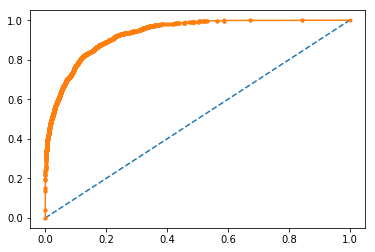

In [0]:
fpr, tpr , thresholds = roc_curve(test_y, pred[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
print(fpr,tpr)
plt.plot(fpr , tpr,marker='.')
plt.show()

# 4. 최종 결과

In [0]:
pred = ml_cb_output.predict_proba(test)

In [0]:
result = ml_cb_output.predict(test)

In [0]:
test['DLY'] = result
test['DLY'] = test['DLY'].replace([0,1], ['N', 'Y'])
test['DLY_RATE'] = pred[:,1]

In [0]:
test.to_csv('submit.csv', index=False, encoding='euc-kr')
data.to_csv('data.csv', index=False, encoding='euc-kr')